# **KAGGLE di ALESSANDRO DELL'ORTO (num matricola 876909)**

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
from IPython.display import IFrame

IFrame(src='https://www.redditinc.com/', width=700, height=500)

In 2015, a Reddit user identified as Stuck_In_the_Matrix made public a dataset of Reddit comments for research. The dataset has approximately 1.7 billion comments and takes 250 GB compressed. Each entry contains comment, score, author, subreddit, position in comment tree and other fields that are available through Reddit's API. The aim of this kaggle is to predict the gender of the authors from this his comment and subreddit.

# Load the train data

Firstly, we must load the dataset. We use [Panda](https://pandas.pydata.org/) .

In [3]:
train_data = pd.read_csv("train_data.csv", encoding="utf8")

In [4]:
train_data.head()

,author,subreddit,created_utc,body
0,Shamus_Aran,mylittlepony,1.388534e+09,I don't think we'd get nearly as much fanficti...
1,Riddance,sex,1.388534e+09,"Thanks. I made it up, that's how I got over my..."
2,Secret_Wizard,DragonsDogma,1.388534e+09,Are you sure you aren't confusing Cyclops (the...
3,Penultimatum,malefashionadvice,1.388534e+09,dont do this to me bro
4,7-SE7EN-7,todayilearned,1.388534e+09,That's what we do when we can't find a mate


In [5]:
train_data.author.unique().shape

(5000,)

In [6]:
target = pd.read_csv("train_target.csv")

In [7]:
target.head()

,author,gender
0,RedThunder90,0
1,Lirkmor,1
2,In0chi,0
3,ProjectGrudge,0
4,TehTurtleHermit,0


## Extract the target

We, simply, create a variable with the target values.

In [23]:
y = target.gender

# Feature Extraction

Then, we must extract the features of the authors. We choose to use subreddit subscription and the text of the messages.

## Extract the subreddits

Firstly, we label every subreddit, then we write a vector for each author where each component points to a subreddit, e.g. if an author wrote only in subreddit 2 and 5
    \begin{equation*}
    \mathbf{V} =  \begin{vmatrix}
                    0 \\
                    0 \\
                    1 \\
                    0 \\
                    0 \\
                    1 \\
                   \vdots \\
                  \end{vmatrix}
    \end{equation*}
    
Then, we can build a matrix where the rows are the authors and the columns the subreddits:
$$S= \begin{bmatrix} v_{1} \\ \vdots\\ v_{d} \end{bmatrix}$$

with $d$ the number of author.


In [8]:
subreddits = train_data.subreddit.unique()
subreddits_map = pd.Series(index=subreddits, data=arange(subreddits.shape[0]))

In [9]:
print (subreddits)

['mylittlepony' 'sex' 'DragonsDogma' ... 'mumfordandsons' 'infertility'
 'HangoutFest']


In [10]:
print (subreddits_map)

mylittlepony            0
sex                     1
DragonsDogma            2
malefashionadvice       3
todayilearned           4
                     ... 
palegirls            3463
onions               3464
mumfordandsons       3465
infertility          3466
HangoutFest          3467
Length: 3468, dtype: int64


In [11]:
from scipy import sparse

def extract_features(group):

    group_subreddits = group['subreddit'].values
    idxs = subreddits_map[group_subreddits].values
    v = sparse.dok_matrix((1, subreddits.shape[0]))
    for idx in idxs:
        if not np.isnan(idx):
            v[0, idx] = 1
    return v.tocsr()

def subreddit_features(data,train=True):
    
    features_dict = {}
    for author, group in data.groupby('author'):
        features_dict[author] = extract_features(group)
    
    if train==True:
        X = sparse.vstack([features_dict[author] for author in target.author])
    else:
        X = sparse.vstack([features_dict[author] for author in data.author.unique()])
    return X

In [12]:
S=subreddit_features(train_data)



In [13]:
print ('# of author',S.shape[0])
print ('# of subreddit', S.shape[1])

# of author 5000
# of subreddit 3468


## Extract the message

We write a dictionary where the keys are the authors and the values are the messages. Before adding the messages to the dict, we clean them from the http links and the punctuation.
Then, we remove the stopwords (a modified list of english stopwords) and [tokenize](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization)  the words of the messages.
    
Finally, we use $TF-IDF$ representation. 

*Tf means term-frequency while $TF-IDF$ means term-frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval, that has also found good use in document classification. The goal of using $TF-IDF$ instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.* 

Theformula  of $TF-IDF$ for a word $t$ of a document $d$ in a document set is 

$$ TF-IDF(t, d) = TF(t, d) \cdot IDF(t) $$

where the IDF is:

$$\mathrm{IDF}(t, D) = \log \frac{|D|}{|\{d \in D: t \in d\}|}$$

with

  * $|D| $ is the total number of documents;
  * $|\{d \in D: t \in d\}|$ is the number of documents where the term $t$ appears.
  
And the TF is:

$$\mathrm{TF}(t,d) = 0.5 + \frac{0.5 \times \mathrm{f}(t, d)}{\max\{\mathrm{f}(w, d):w \in d\}}$$

We use *max_features* in CountVectorizer to consider the top $N$ max_features ordered by term frequency across the corpus. We choose, after several tests, $N=15000$.

In [3]:
import nltk

In [4]:
import string
from nltk.corpus import stopwords
import re



def extract_text(group):
    group_text=''
    for mess in group['body'].values:
        #print (mess, '\n')
        text = re.sub(r'http\S+', '', str(mess))
        clean = re.sub(r"""
               [,.;@#?!&$*"']+  # Accept one or more copies of punctuation
               \ *           # plus zero or more copies of a space,
               """,
               " ",          # and replace it with a single space
               text, flags=re.VERBOSE)
        group_text +=''.join(clean)
    return group_text

def text_features(data,train=True):
    text_dict = {}
    for author, group in data.groupby('author'):
        text_dict[author] = extract_text(group)
    
    if train==True:
        author_text = [text_dict[author] for author in target.author]
    else:
        author_text = [text_dict[author] for author in data.author.unique()]
    return author_text
    


In [16]:
print ((train_data[train_data.author=='RedThunder90'])['body'].values)

['I still prefer to buy foods either grown locally or where animals are treated better, but this definitely has me looking at organic food differently.']


In [17]:
author_text = text_features(train_data)

author_text[0]

'I still prefer to buy foods either grown locally or where animals are treated better but this definitely has me looking at organic food differently '

In [323]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer

from nltk.stem import LancasterStemmer

import string 

my_stopwords=(stopwords.words('english')+['mon'])





In [444]:
cntvec = CountVectorizer(#ngram_range=(1,2),max_features=20000,min_df=3,tokenizer=StemTokenizer(),
                        stop_words=my_stopwords,max_features=15000) 
C = cntvec.fit_transform(author_text)
tfidf = TfidfTransformer(sublinear_tf=True)
M = tfidf.fit_transform(C)

In [445]:
print ('# of author',M.shape[0])
print ('# of words', M.shape[1])

# of author 5000
# of words 15000


## Concatenation of features

We concatenate the matrices of features:

$$S= \begin{bmatrix} s_{11} & \ldots & s_{1N_s} \\ \vdots &  & \vdots \\ s_{d1} & \ldots & s_{dN_s} \end{bmatrix} \;\;\; M= \begin{bmatrix} m_{11} & \ldots & m_{1N_m} \\ \vdots &  & \vdots \\ m_{d1} & \ldots & x_{dN_m} \end{bmatrix} \rightarrow X= \begin{bmatrix} s_{11} & \ldots & s_{1N_s} & m_{11} & \ldots & m_{1N_m} \\ \vdots &  & \vdots & \vdots &  & \vdots \\ s_{d1} & \ldots & s_{dN_s}& m_{d1} & \ldots & x_{dN_m} \end{bmatrix}$$

where 
 * $N_s$ the number of subreddits
 * $N_m$ the number of words

Then we use it to train our model.

In [446]:
X= sparse.hstack([S,M])

In [447]:
print ('# of author',X.shape[0])
print ('# of features', X.shape[1])

# of author 5000
# of features 18468


# Model Selection



We use cross validation to choose the right number of features to select.

We analyze:
 * [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) : it implements the naive Bayes algorithm for multinomially distributed data. Using Bayes theorem and doing some algebrical tricks, we have 
 
   $$ \log P(y \mid \mathbf{x})  \varpropto b + \mathbf{\theta}_y^\top \mathbf{x}$$
 
   where
   
   $$b = \log p(y)$$
   
   and 
   
   $$\mathbf{\theta}_y^\top \mathbf{x}=\log \left ( \prod_{i=1}^{D} p(x_i \mid y) \right )=\sum_{i=1}^n x_i \cdot \log p_{i}$$
      
   The parameter is estimated by a smoothed version of maximum likelihood, i.e. relative frequency counting:
   
    $$\hat{\theta}_{yi} = \frac{ N_{yi} + \alpha}{N_y + \alpha n}$$ 
    
    where $N_{yi} = \sum_{x \in T} x_i$ is the number of times feature $i$ appears in a sample of class $y$ in the training set $T$, and $N_{y} = \sum_{i=1}^{|T|} N_{yi}$ is the total count of all features for class $y$. The smoothing priors $\alpha \ge 0$ accounts for features not present in the learning samples and prevents zero probabilities in further computations. Setting $\alpha = 1$ is called *Laplace smoothing*, while $\alpha < 1$ is called *Lidstone smoothing*.
    
    
 
 * [Complement Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#complement-naive-bayes)  : this classifier was designed to correct the “severe assumptions” made by the standard Multinomial Naive Bayes classifier. The procedure for calculating the weights is as follows:
   $$ \begin{align}\begin{aligned}\hat{\theta}_{ci} = \frac{\alpha_i + \sum_{j:y_j \neq c} d_{ij}}
                         {\alpha + \sum_{j:y_j \neq c} \sum_{k} d_{kj}}\\w_{ci} = \log \hat{\theta}_{ci}\\w_{ci} = \frac{w_{ci}}{\sum_{j} |w_{cj}|}\end{aligned}\end{align} $$ 
    where the summations are over all documents $j$ not in class $c$; $d_ij$ is the  tf-idf value of term $i$ in document $j$; $\alpha = \sum_{i} \alpha_i$  where $\alpha_i$ is a smoothing hyperparameter. The second normalization addresses the tendency for longer documents to dominate parameter estimates in MNB. Finally, the classification rule is: $$\hat{c} = \arg\min_c \sum_{i} t_i w_{ci}$$ i.e., a document is assigned to the class that is the poorest complement match.

To reduce the number of features (to prevent overfitting) we use a filter method based on chi square test. The following image best describes filter-based feature selection methods:

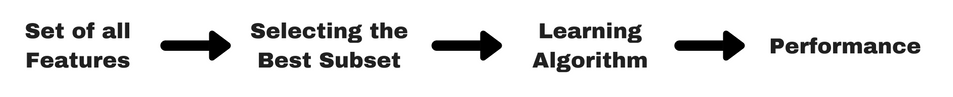
Image Source: Analytics Vidhya

*A chi-square test is used in statistics to test the independence of two events.*

Chi-Square measures how the expected value $E$ and the observed one $O$ deviates each other, i.e.

$${\chi}^2=\frac{1}{d}\sum_{k=1}^{n} \frac{(O_k - E_k)^2}{E_k}$$


In feature selection, we want to select the features which are **highly dependent**. In simple words, higher the Chi-Square value the feature is more dependent on the response and it can be selected for model training.

In [448]:
from sklearn.naive_bayes import MultinomialNB,ComplementNB

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif,chi2

from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import Pipeline

In [449]:
import numpy as np


def plot_confusion_matrix(cm,target_names,title='Confusion matrix', cmap=None,normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.show()

We split the dataset in train set and test set.

In [512]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

In [513]:
clf = MultinomialNB()
sel = SelectKBest()

pipeline   = Pipeline([('sel', sel), ('clf', clf)])

parameters = {'sel__k':np.arange(9000,13000,1000),
              'sel__score_func':[chi2,f_classif],
              'clf__alpha':np.logspace(-3,1,10)
             }

scorers    = {'f1_score': make_scorer(f1_score),
              'recall_score': make_scorer(recall_score),
              'precision_score': make_scorer(precision_score)
             }

gsm = GridSearchCV(pipeline,param_grid=parameters
        ,scoring=scorers,refit='f1_score',cv=10,n_jobs=10,verbose=2)
gsm.fit(X_train, y_train)
print (gsm.best_params_, gsm.best_score_)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:   10.4s
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:   17.9s


{'clf__alpha': 0.1668100537200059, 'sel__k': 11000, 'sel__score_func': <function chi2 at 0x7f33e31c18c0>} 0.7535767658707774


[Parallel(n_jobs=10)]: Done 800 out of 800 | elapsed:   22.3s finished


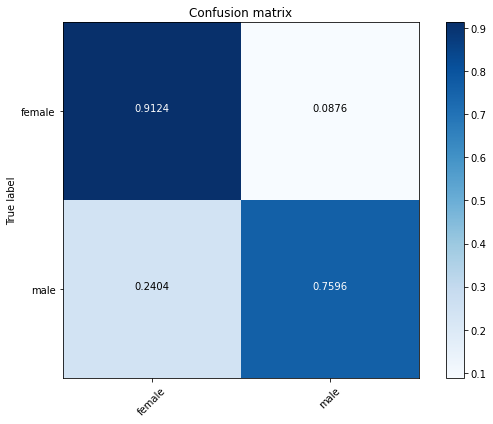

In [514]:
predic = gsm.predict(X_test)

target_names = ['female','male']

confm = confusion_matrix(y_test, predic,normalize='true')
plot_confusion_matrix(confm,target_names)

In [515]:
print(metrics.classification_report(y_test, predic))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       913
           1       0.76      0.76      0.76       337

    accuracy                           0.87      1250
   macro avg       0.84      0.84      0.84      1250
weighted avg       0.87      0.87      0.87      1250



In [476]:
clf = ComplementNB()
sel = SelectKBest()

pipeline   = Pipeline([('sel', sel), ('clf', clf)])

parameters = {'sel__k':np.arange(9000,13000,1000),
              'sel__score_func':[chi2,f_classif],
              'clf__alpha':np.logspace(-3,1,10)
             }

scorers    = {'f1_score': make_scorer(f1_score),
              'recall_score': make_scorer(recall_score),
              'precision_score': make_scorer(precision_score)
             }

gsc = GridSearchCV(pipeline,param_grid=parameters
        ,scoring=scorers,refit='f1_score',cv=10,n_jobs=10,verbose=2)
gsc.fit(X_train, y_train)
print (gsc.best_params_, gsc.best_score_)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 264 tasks      | elapsed:    6.1s
[Parallel(n_jobs=10)]: Done 670 tasks      | elapsed:   14.9s


{'clf__alpha': 0.46415888336127775, 'sel__k': 11000, 'sel__score_func': <function chi2 at 0x7f33e31c18c0>} 0.7470224460031624


[Parallel(n_jobs=10)]: Done 800 out of 800 | elapsed:   17.7s finished


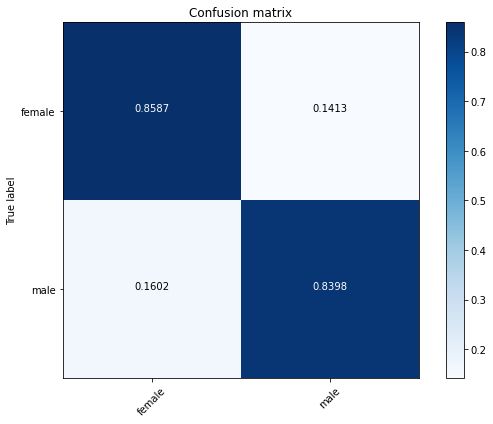

In [477]:
predic = gsc.predict(X_test)

target_names = ['female','male']

confm = confusion_matrix(y_test, predic,normalize='true')
plot_confusion_matrix(confm,target_names)

In [478]:
print(metrics.classification_report(y_test, predic))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90       913
           1       0.69      0.84      0.76       337

    accuracy                           0.85      1250
   macro avg       0.81      0.85      0.83      1250
weighted avg       0.87      0.85      0.86      1250



Now, we fit the best MNB and CNB models on the full dataset and finally, we determine the *stability* of our models using the cross validation on the full dataset.

In [508]:
best_mnb=gsm.best_estimator_
best_mnb.fit(X,y)
scores=cross_val_score(best_mnb, X, y, cv=5,scoring=make_scorer(f1_score))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.76 (+/- 0.03)


In [509]:
best_cnb=gsc.best_estimator_
best_cnb.fit(X,y)
scoresc=cross_val_score(best_cnb, X, y, cv=5,scoring=make_scorer(f1_score))
print("Accuracy: %0.2f (+/- %0.2f)" % (scoresc.mean(), scoresc.std() * 2))

Accuracy: 0.75 (+/- 0.05)


So the Multinomia Naive Bayes gives the best scores. 

# Prepare the solution

In [486]:
test_data = pd.read_csv("test_data.csv", encoding="utf-8")

In [487]:
test_data.head()

,author,subreddit,created_utc,body
0,ejchristian86,TwoXChromosomes,1.388534e+09,I hadn't ever heard of them before joining thi...
1,ZenDragon,gaming,1.388534e+09,"At 7680 by 4320 with 64x AA, right?"
2,savoytruffle,AskReddit,1.388534e+09,bite me
3,hentercenter,stlouisblues,1.388534e+09,Damn that was a good penalty :(
4,rick-o-suave,army,1.388534e+09,I swore into DEP on 6-OCT and I left 5-NOV und...


In [488]:
test_data.author.unique().shape

(15000,)

In [489]:
S_test=subreddit_features(test_data,train=False)


In [490]:
author_text_test = text_features(test_data,train=False)

In [491]:
C = cntvec.transform(author_text_test)
                    
M_test = tfidf.transform(C)

In [492]:
X_test= sparse.hstack([S_test,M_test])

In [493]:
X_test.shape

(15000, 18468)

In [494]:
y_pred = best_mnb.predict_proba(X_test)[:,1]

In [495]:
solution = pd.DataFrame({"author":test_data.author.unique(), "gender":y_pred})
solution.head(80)

,author,gender
0,ejchristian86,1.000000e+00
1,ZenDragon,2.953627e-13
2,savoytruffle,1.817065e-05
3,hentercenter,2.924392e-06
4,rick-o-suave,1.302858e-02
...,...,...
75,IchBinEinHamburger,3.200843e-09
76,wufoo2,9.855281e-01
77,Tall_LA_Bull,9.965454e-01
78,Junoh315,1.046879e-11


In [496]:
solution.to_csv("solutio_best.csv", index=False)